In [1]:
%matplotlib inline
import h5py
import pandas as pd
import numpy as np
import copy
import os
import sys
import matplotlib

from strategy import handle_bar
# from strategy import handle_bar

Using TensorFlow backend.


In [2]:
! ls ../../data/

data_format1_201801.h5
data_format1_201802.h5
data_format1_201803.h5
data_format1_201804.h5
data_format1_201805.h5
data_format1_201806.h5
data_format1_201807.h5
data_format1_201808.h5
data_format1_20180901_20180909.h5
data_format1_20180909_20180916.h5
data_format1_20180916_20180923.h5
data_format1_20180923_20180930.h5
data_format1_20180930_20181007.h5
data_format1_20181007_20181014.h5
data_format1_20181014_20181021.h5
data_format1_20181021_20181028.h5
data_format1_20181028_20181104.h5
data_format1_20181104_20181111.h5
data_format1_20181111_20181118.h5
data_format1_data_format1_20181104_20181111.h5.h5
data_format1_data_format1_20181111_20181118.h5.h5
data_format2_201801.h5
data_format2_201802.h5
data_format2_201803.h5
data_format2_201804.h5
data_format2_201805.h5
data_format2_201806.h5
data_format2_201807.h5
data_format2_201808.h5
data_format2_20180901_20180909.h5
data_format2_20180909_20180916.h5
data_format2_20180916_20180923.h5
data_format2_20180923_20180930.h5
data_format2_20180930_

In [3]:
# Change the working directory to your strategy folder.
# You should change this directory below on your own computer accordingly.
working_folder = "./"
#/Users/Chen/Library/Mobile Documents/com~apple~CloudDocs/HKUST/MSBD5013_SP/Python/demo2'#D:\Dropbox\MAFS-2018\Python\demo3'

# Write down your file paths for format 1 and format 2
# Note: You can test your strategy on different periods. Try to make your strategy profitable stably.
format1_dir = '../../data/data_format1_20181014_20181021.h5'
format2_dir = '../../data/data_format2_20181014_20181021.h5'

# The following code is for backtesting. DO NOT change it unless you want further exploration beyond the course project.
# import your handle_bar function
sys.path.append(working_folder)

# Run the main function in your demo.py to get your model and initial setup ready (if there is any)
os.chdir(working_folder)
os.system('python strategy.py')

256

In [4]:
# Class of memory for data storage
class memory:
    def __init__(self):
        pass


class backTest:
    def __init__(self):
        # Initialize strategy memory with None. New memory will be updated every minute in backtest
        self.memory = memory()
        
        # Initial setting of backtest
        self.init_cash = 100000.
        self.cash_balance_lower_limit = 10000.
        self.commissionRatio = 0.0005
        
        # Data path
        self.data_format1_path = format1_dir
        self.data_format2_path = format2_dir
        
        # You can adjust the path variables below to train and test your own model
        self.train_data_path = ''
        self.test_data_path = ''
    
    def pnl_analyze(self, strategyDetail):
        balance = strategyDetail.total_balance
        balance_hourly = balance.resample("H").last()
        ret_hourly = balance_hourly.pct_change()
        ret_hourly[0] = balance_hourly[0] / self.init_cash - 1
        ret_hourly.fillna(0, inplace=True)

        balance_daily = balance.resample("D").last()
        ret_daily = balance_daily.pct_change()
        ret_daily[0] = balance_daily[0] / self.init_cash - 1
        ret_daily.fillna(0, inplace=True)

        total_ret = balance[-1] / balance[0] - 1
        daily_ret = ret_daily.mean()
        sharpe_ratio = np.sqrt(365) * ret_daily.mean() / ret_daily.std()
        max_drawdown = (balance / balance.cummax() - 1).min()

        print("Total Return: ", total_ret)
        print("Average Daily Return: ", daily_ret)
        print("Sharpe Ratio: ", sharpe_ratio)
        print("Maximum Drawdown: ", max_drawdown)

        balance_hourly.plot(figsize=(12, 3), title='Balance Curve', grid=True)
        matplotlib.pyplot.show(block=True)

        pass

    def backTest(self):

        ''' Function that used to do back-testing based on the strategy you give
        Params: None
        
        Notes: this back-test function will move on minute bar and generate your 
        strategy detail dataframe by using the position vectors your strategy gives
        each minute
        '''

        format1 = h5py.File(self.data_format1_path, mode='r')
        format2 = h5py.File(self.data_format2_path, mode='r')
        assets = list(format1.keys())
        keys = list(format2.keys())

        for i in range(len(keys)):
            data_cur_min = format2[keys[i]][:]
            # 1. initialization
            if i == 0:
                total_balance = self.init_cash
                average_price_old = np.mean(data_cur_min[:,:4], axis=1)
                position_old = np.repeat(0., 4)
                position_new = np.repeat(0., 4)
                details = list()
                stop_signal = False

            # 2. calculate position & cash/crypto/total balance & transaction cost etc.
            position_change = position_new - position_old
            mask = np.abs(position_change) > .25*data_cur_min[:,4]
            position_change[mask] = (.25*data_cur_min[:,4]*np.sign(position_change))[mask]
            position_new = position_old + position_change
            average_price = np.mean(data_cur_min[:, :4], axis=1)
            transaction_cost = np.sum(np.abs(position_change)*average_price*self.commissionRatio)
            revenue = np.sum(position_old*(average_price - average_price_old)) - transaction_cost
            crypto_balance = np.sum(np.abs(position_new*average_price))
            total_balance = total_balance + revenue
            cash_balance = total_balance - crypto_balance
            detail = np.append(position_new, [cash_balance, crypto_balance, revenue, total_balance, transaction_cost])
            details.append(copy.deepcopy(detail))

            position_old = copy.deepcopy(position_new)
            average_price_old = copy.deepcopy(average_price)

            # 3. check special cases
            # if cash balance is less than lower limit, the program will stop all trading actions in the future
            if (cash_balance < self.cash_balance_lower_limit) and (stop_signal == False):
                stop_signal = True
                print("Current cash balance is lower than", self.cash_balance_lower_limit)
                print("Your strategy is forced to stop")

            if stop_signal:
                if '09:30:00' in keys[i]:
                    print(keys[i][:10])
                continue
            
            # Update position and memory
            [position_new, self.memory] = handle_bar(i,
                                                     keys[i],
                                                     data_cur_min,
                                                     self.init_cash,
                                                     self.commissionRatio,
                                                     cash_balance,
                                                     crypto_balance,
                                                     total_balance,
                                                     position_new,
                                                     self.memory)

            # Update position and timer
            if '09:30:00' in keys[i]:
                print(keys[i][:10])
            
        detailCol = assets + ["cash_balance", "crypto_balance", "revenue", "total_balance", "transaction_cost"]
        detailsDF = pd.DataFrame(details, index=pd.to_datetime(keys), columns=detailCol)

        format1.close()
        format2.close()
        return detailsDF

/Users/leonling/workspace/Projects/IPython/CurrencyPrediction/submissions/1111/strategy.py:89: RuntimeWarning: invalid value encountered in double_scalars
  return_rate = (abs(cryp_balance-return_balance) - transaction_cost) / cryp_balance
/Users/leonling/workspace/Projects/IPython/CurrencyPrediction/submissions/1111/strategy.py:174: RuntimeWarning: Mean of empty slice.
  x.append(bar_x.values[start:end, 0].mean())
/Users/leonling/workspace/pyenv/py36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/leonling/workspace/Projects/IPython/CurrencyPrediction/submissions/1111/strategy.py:89: RuntimeWarning: divide by zero encountered in double_scalars
  return_rate = (abs(cryp_balance-return_balance) - transaction_cost) / cryp_balance


2018-10-14
2018-10-15
Not trust BTC-USD model now, but still use it
Not trust ETH-USD model now, but still use it
Not trust LTC-USD model now, but still use it
2018-10-16
2018-10-17
Not trust BTC-USD model now, but still use it
Not trust ETH-USD model now, but still use it
Not trust LTC-USD model now, but still use it
2018-10-18
2018-10-19
Not trust BTC-USD model now, but still use it
Not trust ETH-USD model now, but still use it
Not trust LTC-USD model now, but still use it
2018-10-20
Total Return:  -0.0017221979370757312
Average Daily Return:  -0.00021539849601828753
Sharpe Ratio:  -13.85283572734657
Maximum Drawdown:  -0.0018272581043017322


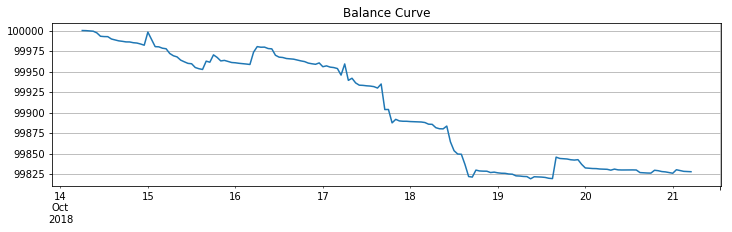

In [5]:
''' You can check the details of your strategy and do your own analyze by viewing 
the strategyDetail dataframe
'''
bt = backTest()
strategyDetail = bt.backTest()
strategyDetail.to_csv(working_folder+"/backtest_details.csv")  # output backtest details to your working folder
bt.pnl_analyze(strategyDetail)  # print performance summary, plot balance curve`

In [6]:
# from sklearn.externals import joblib
# from keras.models import load_model

# ASSETS = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']
# model_list = []
# for model_name in ASSETS:
#     model_path = './model_' +model_name.lower() + '.h5'
#     print(model_path)
#     model_list.append(load_model(model_path))